In [1]:
import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import *

In [11]:
isHIP = False

def is_cuda():
    return not isHIP

def is_hip_mi200():
    return isHIP

def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64}, num_stages=4,
                      num_warps=4)
    ]


def get_hip_autotune_config():
    return [
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'waves_per_eu': 2},
            num_warps=4, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'waves_per_eu': 2},
            num_warps=8, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'waves_per_eu': 2},
            num_warps=8, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'waves_per_eu': 3},
            num_warps=4, num_stages=0),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'waves_per_eu': 8},
            num_warps=4, num_stages=0),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        return get_hip_autotune_config()

In [12]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matrix_mult(A, B, C, 
                M, K, N, 
                stride_am, stride_ak,  #
                stride_bk, stride_bn,  #
                stride_cm, stride_cn,
                BLOCK_SIZE_M : tl.constexpr, BLOCK_SIZE_K : tl.constexpr, BLOCK_SIZE_N : tl.constexpr):
    """
    C := A x B
    """
    pid_m = tl.program_id(axis=0)
    pid_n = tl.program_id(axis=1)

    # tl.store(C + BLOCK_SIZE_M * pid_m * N + pid_n * BLOCK_SIZE_N, pid_m)

    # current block m-wise
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M))# % M
    # current block n-wise
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N))# % N
    # current k offset
    offs_k = tl.arange(0, BLOCK_SIZE_K)

    # acc
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    # A pointer block and B pointer block
    a_ptrs = A + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = B + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    
    # We accumulate along the K dimension.
    # for pid_k in range(0, (K + BLOCK_SIZE_K - 1) // BLOCK_SIZE_K):
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        #  & (offs_am[:, None] < M)
        #  & (offs_bn[None, :] < N)
        a = tl.load(a_ptrs, mask=(offs_k[None, :] < K) & (offs_am[:, None] < M), other=0.0)
        b = tl.load(b_ptrs, mask=(offs_k[:, None] < K) & (offs_bn[None, :] < N), other=0.0)
        # We accumulate along the K dimension.
        acc += tl.dot(a, b)

        # update block k-wise
        offs_k += BLOCK_SIZE_K

        # update a and b pointers
        # by taking advantage of pointer arithmetic
        # (each value in a advances by BLOCK_SIZE_K columns,
        # and each value in b advances by BLOCK_SIZE_K rows)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        # get k x n block in B
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c_start = C + BLOCK_SIZE_M * pid_m * stride_cm + pid_n * BLOCK_SIZE_N * stride_cn

    this_block = c_start + tl.arange(0, BLOCK_SIZE_M)[:, None] * stride_cm + tl.arange(0, BLOCK_SIZE_N)[None, :] * stride_cn

    acc = acc.to(tl.float16)
    tl.store(this_block, acc, mask=(offs_am[:, None] < M) & (offs_bn[None, :] < N))

In [13]:
def matmul(a, b):
    M, K = a.shape
    K, N = b.shape
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']), triton.cdiv(N, META['BLOCK_SIZE_N']), )
    c = torch.zeros((M, N), device="cuda", dtype=torch.float16)
    matrix_mult[grid]\
        (a, b, c, 
         M, K, N,
         a.stride(0), a.stride(1),  #
         b.stride(0), b.stride(1),  #
         c.stride(0), c.stride(1),  #
         )
    return c

In [14]:
import time
from math import ceil

xs = []
triton_times = []
torch_times = []
works = []

for i in range(64, 10000, 64):
    xs.append(i)
    
    M = i
    N = i
    K = i
    
    a = torch.randn((M, K), device="cuda", dtype=torch.float16)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16)

    # warmup time for autotuner
    for i in range(5):
        c = matmul(a, b)
        del c

    torch.cuda.synchronize()
    start_time = time.time()
    c = matmul(a, b)
    torch.cuda.synchronize()
    elapsed = time.time() - start_time

    triton_times.append(elapsed)

    for i in range(5):
        torch_result = torch.matmul(a, b)
        del torch_result
    
    #indices = torch.randint(i, (2,))
    torch.cuda.synchronize()
    start_time = time.time()
    torch_result = torch.matmul(a, b)
    torch.cuda.synchronize()
    #print(torch_result[indices[0]][indices[1]])
    elapsed = time.time() - start_time

    torch_times.append(elapsed)

    max_diff = torch.max(torch_result - c)
    print(max_diff, '< 1e-2 ?', max_diff < 1e-2)

    works.append(max_diff.item())

    del a
    del b
    del c
    del torch_result

tensor(3.8147e-06, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(True, device='cuda:0')
tensor(0.0078, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(True, device='cuda:0')
tensor(0.0156, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0156, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0156, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0156, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0312, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor(False, device='cuda:0')
tensor(0.0625, device='cuda:0', dtype=torch.float16) < 1e-2 ? tensor

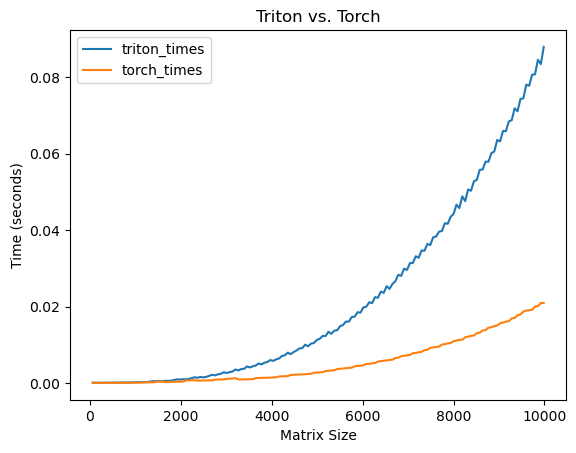

In [16]:
import matplotlib.pyplot as plt
# Plotting both the curves simultaneously
plt.plot(xs, triton_times, label='triton_times')  # Plotting the first line
plt.plot(xs, torch_times, label='torch_times')  # Plotting the second line

# Naming the x-axis, y-axis and the whole graph
plt.xlabel('Matrix Size')
plt.ylabel('Time (seconds)')
plt.title('Triton vs. Torch')

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()